Performing multitaper spectral analysis to _C. elegans_ calcium data.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import fft
from spectrum import Spectrogram, dolphin_filename, readwav
from data._utils import pick_worm, load_dataset

# Using the imported module `spectrum`

```
import Periodogram, pmtm
import numpy as np


__all__ = ["Spectrogram"]


[docs]class Spectrogram(object):
    """Simple example of spectrogram

    .. plot::

        from spectrum import Spectrogram, dolphin_filename, readwav
        data, samplerate = readwav(dolphin_filename)

        p = Spectrogram(data, ws=128, W=4096, sampling=samplerate)
        p.periodogram()
        p.plot()

    .. warning:: this is a prototype and need careful checking about x/y axis


    """
    def __init__(self, signal, ws=128, W=4096, sampling=1, channel=1):
        if len(signal.shape) == 1:
            self.signal = signal
        else:
            self.signal = signal[:,channel-1]
        self.W = W
        self.ws = ws
        self._start_y = 10
        self.sampling = sampling
        self.duration = len(self.signal) / float(self.sampling)

[docs]    def plot(self, filename=None, vmin=None, vmax=None, cmap='jet_r'):
        import pylab
        pylab.clf()
        pylab.imshow(-np.log10(self.results[self._start_y:,:]), 
            origin="lower",
            aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        pylab.colorbar()

        # Fix xticks
        XMAX = float(self.results.shape[1])  # The max integer on xaxis
        xpos = list(range(0, int(XMAX), int(XMAX/5)))
        xx = [int(this*100)/100 for this in np.array(xpos) / XMAX * self.duration]
        pylab.xticks(xpos, xx, fontsize=16)

        # Fix yticks
        YMAX = float(self.results.shape[0])  # The max integer on xaxis
        ypos = list(range(0, int(YMAX), int(YMAX/5)))
        yy = [int(this) for this in np.array(ypos) / YMAX * self.sampling]
        pylab.yticks(ypos, yy, fontsize=16)

        #pylab.yticks([1000,2000,3000,4000], [5500,11000,16500,22000], fontsize=16)
        #pylab.title("%s echoes" %  filename.replace(".png", ""), fontsize=25)
        pylab.xlabel("Time (seconds)", fontsize=25)
        pylab.ylabel("Frequence (Hz)", fontsize=25)
        pylab.tight_layout()
        if filename:
            pylab.savefig(filename)


[docs]    def periodogram(self):
        W = self.W
        ws = self.ws
        N = int(len(self.signal)/ws)
        self.results = np.zeros((W*2+1, N-8))
        print("Duration: %s" % self.duration)
        print("W: %s" % W)
        print("ws: %s" % ws)
        print("Computing %s TFs" % N)
        for i in range(N-8):
            data = self.signal[i*ws:i*ws+W]
            p = Periodogram(data, sampling=self.sampling, NFFT=W*4)
            p()
            self.results[:,i] = p.psd
        print("done")


[docs]    def pmtm(self):
        W = self.W
        ws = self.ws
        N = int(len(self.signal) / ws)
        self.results = np.zeros((W+1, N-8))
        for i in range(N-8):
            data = self.signal[i*ws:i*ws+W]
            a = pmtm(data, 4, NFFT=W*4, show=False)
            Sk = np.mean(abs(a[0].transpose())**2 * a[1], axis=1)
            self.results[:, i] = Sk[0:self.W+1]
            print(i, N)
        print("done")
```

In [79]:
help(Spectrogram)


Help on class Spectrogram in module spectrum.spectrogram:

class Spectrogram(builtins.object)
 |  Spectrogram(signal, ws=128, W=4096, sampling=1, channel=1)
 |  
 |  Simple example of spectrogram
 |  
 |  .. plot::
 |  
 |      from spectrum import Spectrogram, dolphin_filename, readwav
 |      data, samplerate = readwav(dolphin_filename)
 |  
 |      p = Spectrogram(data, ws=128, W=4096, sampling=samplerate)
 |      p.periodogram()
 |      p.plot()
 |  
 |  .. warning:: this is a prototype and need careful checking about x/y axis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, signal, ws=128, W=4096, sampling=1, channel=1)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  periodogram(self)
 |  
 |  plot(self, filename=None, vmin=None, vmax=None, cmap='jet_r')
 |  
 |  pmtm(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variabl

Based on the source code provided, `ws` and `W` appear to be related to the windowing of the signal before applying the Periodogram and multitaper methods (pmtm). 

Here's a more detailed breakdown:

- `ws`: This parameter represents the window size in the time domain. It determines the number of samples per window or segment over which the Periodogram or multitaper methods will be applied. In the loop where the Periodogram or multitaper methods are applied, you can see `data = self.signal[i*ws:i*ws+W]`, which is selecting a window of the signal to process. 

- `W`: This parameter is used as the size of the Fourier transform (or in general, the size of the frequency domain representation). It is passed as the `NFFT` argument to the `Periodogram` and `pmtm` functions, which stands for the number of points used in the discrete Fourier Transform. It seems to determine the frequency resolution of the spectrogram, i.e., how many points will be used to represent the signal in the frequency domain for each time window.

In essence, `ws` and `W` are used to control the time-frequency resolution trade-off in the spectrogram. A smaller `ws` will give you a better temporal resolution (more precise location of changes in frequency), but worse frequency resolution (less precise identification of the frequency content), and vice versa. Similarly, a larger `W` will provide more frequency bins (increased frequency resolution), but it may also imply more computations.

The `sampling` argument refers to the sampling rate of your signal, which is the number of times measurements are taken per second. 

In your case, given that your calcium data is sampled at regular intervals of 0.25 seconds, your sampling rate would be 1/0.25 = 4 Hz (Hertz, which is the unit for frequency in cycles per second).

So, if you were to use this `Spectrogram` class from the `spectrum` package for your calcium data, you would want to set `sampling=4`, which represents the fact that you are taking 4 measurements every second.

This sampling rate is essential for correctly interpreting the frequency content of your signal. The frequency components resulting from the Fourier transform are relative to this sampling rate. In other words, the Fourier Transform gives you the signal's frequency content in terms of cycles per sample interval. To convert this to a physical frequency (like Hz), you need to know your sampling rate. 

For instance, a frequency component at 1 Hz would correspond to a repeating pattern in your signal that occurs four times (since your sampling rate is 4 Hz).

In [88]:
# Example
data, samplerate = readwav(dolphin_filename)

p = Spectrogram(data, ws=128, W=4096, sampling=samplerate)
print("shape of data:", data.shape)

shape of data: (156929,)


The `periodogram` and `pmtm` methods in the `Spectrogram` class are both methods to estimate the Power Spectral Density (PSD) of a signal. The PSD describes how the power of a signal or time series is distributed with frequency. Here is what each method does:

1. `periodogram`: The periodogram is a basic method for estimating the PSD of a signal. It is based on the Fast Fourier Transform (FFT) of the signal. The `Periodogram` class from the `spectrum` package first takes the FFT of the input signal, then it calculates the magnitude squared of the result to obtain the PSD. This method assumes the signal is stationary (i.e., its properties do not change over time). 

2. `pmtm`: This stands for Multitaper method spectrum estimation using adaptive weights, also known as Thomson's Multitaper method. This is a more advanced method for spectral density estimation. The idea is to take multiple "windows" (tapers) of the data and average the PSD estimated from each window. The key advantage of this method over the basic periodogram is that it can handle signals that are not strictly stationary, and it has better spectral resolution and variance properties. The method uses multiple orthogonal "tapers", which are applied to the time series data to create multiple independent estimates of the power spectrum. The resulting spectra are then combined adaptively to produce the final spectral estimate. 

In summary, the main difference between `periodogram` and `pmtm` is the method they use for estimating the PSD. The multitaper method (`pmtm`) is generally more accurate and reliable than the periodogram, especially for dealing with non-stationary data or data with a low signal-to-noise ratio. The trade-off is that `pmtm` is computationally more intensive than `periodogram`.

Duration: 7.116961451247166
W: 4096
ws: 128
Computing 1226 TFs
done


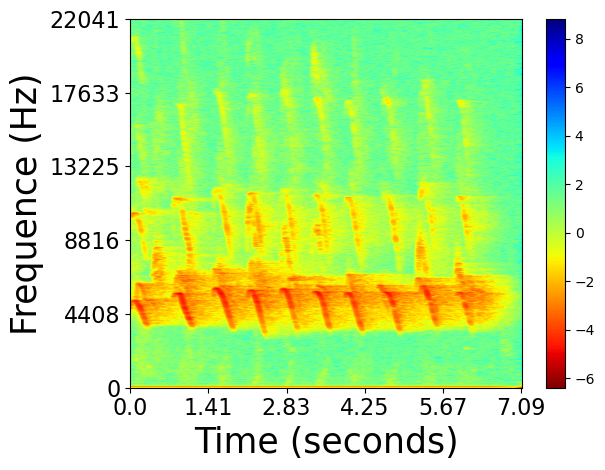

In [81]:
p.periodogram()
p.plot()

In [89]:
# My data
Kato2015 = load_dataset("Kato2015")
single_worm_dataset = pick_worm(Kato2015, 0)
dt = single_worm_dataset["resample_median_dt"]
sampling_rate = 1 / dt
calcium_data = single_worm_dataset["calcium_data"].numpy()
print(
    "shape of calcium data:", calcium_data.shape, "= (time, neurons)"
)  #  time x neurons

p = Spectrogram(calcium_data[:, 8], ws=8, W=128, sampling=sampling_rate)

shape of calcium data: (719, 302) = (time, neurons)


Both the periodogram and the spectrogram are used for spectral analysis of a signal. They each provide a way to visualize the frequency content of a signal, but they are used in slightly different ways and provide different types of information.

1. **Periodogram**: The periodogram is a basic tool used in signal processing for estimating the Power Spectral Density (PSD) of a signal. The PSD is a measure of the signal's power intensity in the frequency domain. The periodogram is computed by taking the Fourier Transform of the signal, which converts the signal from the time domain to the frequency domain, and then taking the magnitude squared of the result. This provides a plot of the signal's power (on the y-axis) as a function of frequency (on the x-axis). The periodogram assumes that the signal is stationary, which means that its statistical properties do not change over time.

2. **Spectrogram**: The spectrogram, on the other hand, is a visualization tool that depicts how the spectral density of a signal varies over time. In other words, it provides a time-frequency representation of the signal. It's essentially a series of periodograms, computed for successive time windows of the signal, and then plotted as a 2D image. The x-axis represents time, the y-axis represents frequency, and the color or intensity represents the power or amplitude at each time and frequency. The spectrogram allows you to see how the frequency content of the signal changes over time, which makes it useful for analyzing non-stationary signals.

In summary, while a periodogram provides a frequency-based view of a signal, a spectrogram provides a time-frequency view that shows how the spectral content of the signal changes over time.

Duration: 719.0
W: 128
ws: 8
Computing 89 TFs
done


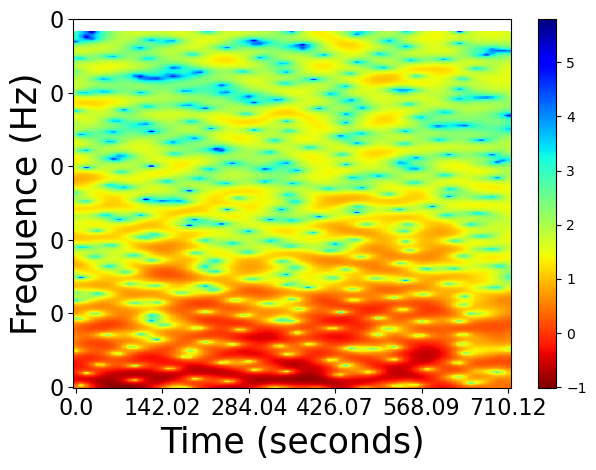

In [90]:
# Simple Periodogram Analysis
p.periodogram()
p.plot()

0 89
1 89
2 89
3 89
4 89
5 89
6 89
7 89
8 89
9 89
10 89
11 89
12 89
13 89
14 89
15 89
16 89
17 89
18 89
19 89
20 89
21 89
22 89
23 89
24 89
25 89
26 89
27 89
28 89
29 89
30 89
31 89
32 89
33 89
34 89
35 89
36 89
37 89
38 89
39 89
40 89
41 89
42 89
43 89
44 89
45 89
46 89
47 89
48 89
49 89
50 89
51 89
52 89
53 89
54 89
55 89
56 89
57 89
58 89
59 89
60 89
61 89
62 89
63 89
64 89
65 89
66 89
67 89
68 89
69 89
70 89
71 89
72 89
73 89
74 89
75 89
76 89
77 89
78 89
79 89
80 89
done


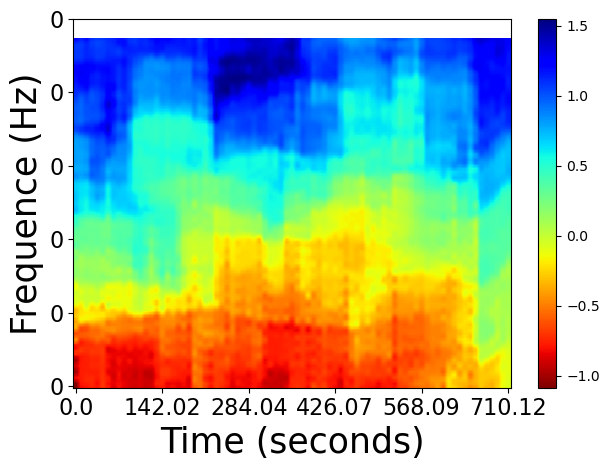

In [91]:
# Multitaper Spectral Analysis
p.pmtm()
p.plot()

The successive time windows used in computing a spectrogram can be either sliding (overlapping) or non-overlapping, depending on the specific method or requirement of the analysis. 

1. **Non-overlapping windows**: In the simplest form, the signal is divided into non-overlapping segments or windows of equal length. Each of these segments is then Fourier transformed to get the frequency content of that segment. The issue with non-overlapping windows is that you may lose some information that lies between the windows.

2. **Overlapping (sliding) windows**: To address the information loss problem of non-overlapping windows, overlapping or sliding windows are often used. In this method, the window slides across the signal with a certain step size or hop length, which is less than the window length. This creates overlapping segments of the signal. The level of overlap can be adjusted according to the requirements of the analysis. Higher overlap can result in better time resolution, but it also requires more computation.

Overlapping windows are commonly used in spectrogram analysis because they can provide a smoother and more accurate time-frequency representation of the signal. They are especially useful for signals that have rapid changes in frequency content.

In the provided `Spectrogram` class code, it appears that non-overlapping windows are being used to calculate the spectrogram.

This is suggested by the following lines of code in both `periodogram` and `pmtm` methods:

```python
for i in range(N-8):
    data = self.signal[i*ws:i*ws+W]
```

In these lines, the time window for each spectral estimate is determined by `i*ws:i*ws+W`, where `i` is the window index, `ws` is the window size (which also seems to define the step size for window shifts), and `W` is the length of the window. The window index `i` increases by 1 for each loop iteration, which suggests that the window is shifting by the full window size `ws` for each step, indicating non-overlapping windows.

If overlapping (or sliding) windows were being used, we would expect to see a smaller step size, typically less than `ws`, for shifting the window.


# Using `scipy.signal.spectrogram` directly

No, `scipy.signal.spectrogram` does not implement the multitaper method for computing spectrograms. It uses Short Time Fourier Transform (STFT) to compute spectrograms, which essentially involves applying a Fourier Transform on short, overlapping segments of the signal.

While the multitaper method and STFT are both methods to compute the spectrogram, they work in fundamentally different ways. The multitaper method uses multiple window functions (the tapers) to reduce variance in the spectrogram, at the cost of reducing frequency resolution. On the other hand, STFT uses a single window function (although the choice of window can vary) and can maintain frequency resolution, but it may have higher variance.

chape of calcium data: (100, 1200) = (neurons, time)
chape of calcium data: (302, 719) = (neurons, time)


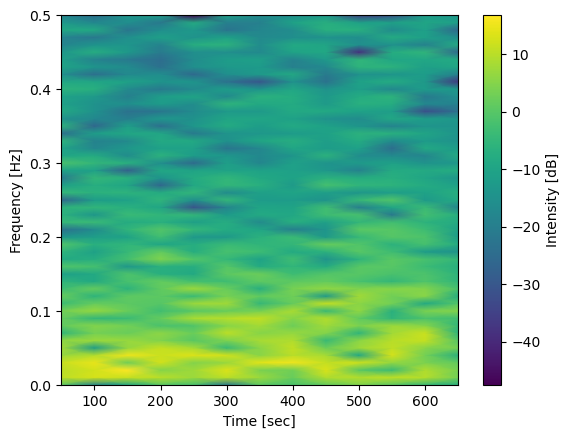

In [85]:
# Assuming calcium_data is your data matrix of shape (num_neurons, max_timesteps)

# using a random example here
num_neurons = 100
max_timesteps = (
    1200  # this would correspond to a 600-second recording at a 4Hz sampling rate
)
calcium_data = np.random.rand(num_neurons, max_timesteps)
print(
    "chape of calcium data:", calcium_data.shape, "= (neurons, time)"
)  # neurons x time

# using my actual data instead
calcium_data = single_worm_dataset["calcium_data"].numpy().T
print(
    "chape of calcium data:", calcium_data.shape, "= (neurons, time)"
)  # neurons x time

# Choose one neuron's data to analyze
neuron_data = calcium_data[8, :]

# Parameters for the spectrogram
fs = sampling_rate  # Sampling frequency
nperseg = 100  # Length of each segment
noverlap = 50  # Number of points to overlap between segments

# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(
    neuron_data, fs, nperseg=nperseg, noverlap=noverlap
)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Intensity [dB]")
plt.show()


# Building the mutitaper method using `scipy.signal.spectogram`.

The multitaper method is a bit more complex than applying the standard Fourier Transform as it uses multiple "tapers", or window functions, to the signal before applying the Fourier Transform. The multiple results are then combined in a way that reduces the variance of the final spectrogram.

The `scipy` library does not natively support the multitaper method for spectrogram calculation, as it requires some additional steps beyond what is implemented in the `scipy.signal.spectrogram` function. The `scipy.signal.spectrogram` function computes the spectrogram using the Short-Time Fourier Transform (STFT), which applies a Fourier Transform to overlapping segments of the signal.

To implement the multitaper method in Python without relying on additional packages like `spectrum` or `mne`, you would need to:

1. Compute the set of tapers to use. The most common choice is the DPSS (Discrete Prolate Spheroidal Sequences), which can be computed using the `scipy.signal.windows.dpss` function.
2. For each taper, multiply it element-wise with the signal. This gives a windowed version of the signal.
3. Apply the Fourier Transform (for example using `numpy.fft.fft`) to each windowed signal.
4. Average the resulting spectra.

Here is a rough example of how you might implement this:


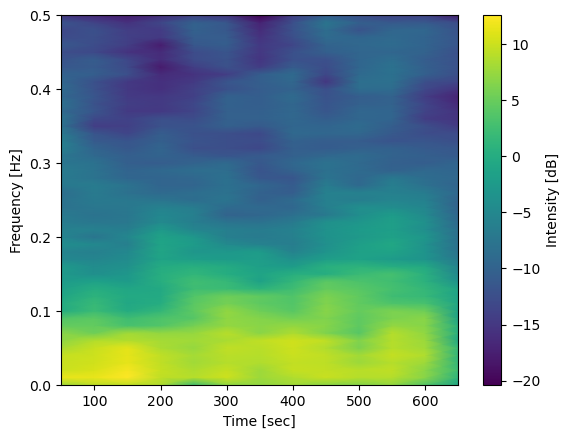

In [86]:
# Custom written multitaper method
def multitaper_spectrogram(y, fs, nperseg, noverlap, NW):
    # Compute the tapers
    tapers = signal.windows.dpss(nperseg, NW, Kmax=2 * NW - 1)

    # Pre-allocate the spectrogram array
    f, t, Sxx = signal.spectrogram(
        y, fs, window=tapers[0], nperseg=nperseg, noverlap=noverlap
    )
    Sxx_multi = np.zeros((len(tapers), len(f), len(t)))

    # Compute the spectrogram for each taper and average them
    for i, taper in enumerate(tapers):
        f, t, Sxx_multi[i] = signal.spectrogram(
            y, fs, window=taper, nperseg=nperseg, noverlap=noverlap
        )
    Sxx = Sxx_multi.mean(axis=0)

    return f, t, Sxx


# Now you can use the function on your data
y = calcium_data[8, :]
fs = sampling_rate
nperseg = 100
noverlap = 50
NW = 4
f, t, Sxx = multitaper_spectrogram(y, fs, nperseg, noverlap, NW)

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Intensity [dB]")
plt.show()

Note that this is a very basic implementation and may not cover all cases. In practice, you would probably want to add more functionality, such as choosing the number of tapers, handling different data types, etc. Furthermore, you would need to decide how to choose the `NW` parameter, which influences the balance between frequency resolution and variance in the spectrogram.

This approach is quite manual and does not offer the same convenience as using a library function, but it gives you more control over the computation and can be a good learning exercise.